#  [SOLUTION] Exercise 1: Implement a Single-Layer Perceptron for AND and XOR Gates

Artificial neurons combine inputs with weights, add a bias, and produce an output. But can this simple computation solve any problem we throw at it? Time to find out by building one yourself and testing it on classic logic problems.

> **Overview**: Implement a perceptron class in PyTorch, manually find weights that solve the AND gate (success!), try multiple approaches to solve XOR (they'll all fail...), then explore why combining multiple neurons changes everything.
> 
> **Scenario**: Your movie recommendation system needs complex decision logic. You'll configure a neuron to implement "recommend only when BOTH rating AND popularity are high" (AND logic), then attempt "recommend when EITHER is high but NOT both" (XOR logic). To understand if single neurons can handle these rules, you'll first test them on simplified binary logic gates, which reveal the fundamental capabilities and limitations that apply to all perceptrons—whether they're classifying movies, or any other data.
> 
> **Goal**: Discover the strengths and limitations of single-layer networks to understand why depth matters in neural networks.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib
> 
> **Estimated Time**: 15 minutes

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
output_dir = 'assets/_SOLUTION-exercise1'
os.makedirs(output_dir, exist_ok=True)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Understand the logic gate problems

Before we start coding, let's understand what AND and XOR gates are, and why they're important test cases for neural networks.

> **What is linear separability?** A dataset is linearly separable if you can draw a straight line (in 2D) or a flat plane (in higher dimensions) that perfectly separates the two classes. 
> 
> - AND gate: ✓ Linearly separable (one line works)
> - XOR gate: ✗ Not linearly separable (no single line works)
> 
> This geometric property determines whether a single neuron can solve the problem!

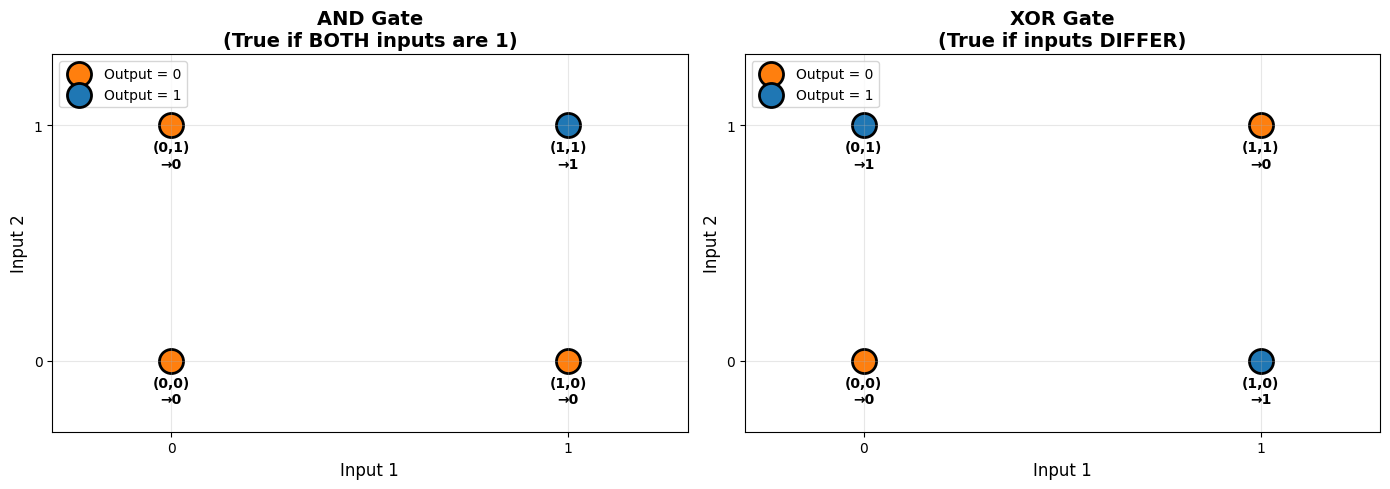


Key observation:
• AND gate: Classes are LINEARLY SEPARABLE
• XOR gate: Classes are NOT linearly separable


In [2]:
# Truth table inputs shared by both gates
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# Corresponding outputs for each logic gate
y_and = np.array([0, 0, 0, 1])
y_xor = np.array([0, 1, 1, 0])

# Create side-by-side plots for AND and XOR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color and label settings for class 0 and class 1
colors = ['#ff7f0e', '#1f77b4']
labels_text = ['Output = 0', 'Output = 1']


def plot_gate(ax, X, y, title, subtitle):
    """
    Plot a truth table for a binary gate:
    - scatters points for each input pair
    - colors them according to their output class
    - annotates each point with (x1,x2) and output
    """

    # Plot points for each output class (0 and 1)
    for cls in (0, 1):
        mask = (y == cls)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=colors[cls],
            s=300,
            label=labels_text[cls],
            edgecolors='black',
            linewidth=2
        )

    # Annotate each point with its input and output value
    for (x1, x2), out in zip(X, y):
        ax.text(
            x1, x2 - 0.18,
            f"({x1},{x2})\n→{out}",
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

    # Apply consistent visual formatting to the axes
    ax.set_xlabel('Input 1', fontsize=12)
    ax.set_ylabel('Input 2', fontsize=12)
    ax.set_title(f'{title}\n({subtitle})', fontsize=14, fontweight='bold')
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 1.3)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])


# Plot AND and XOR truth tables using the shared function
plot_gate(axes[0], X, y_and, 'AND Gate', 'True if BOTH inputs are 1')
plot_gate(axes[1], X, y_xor, 'XOR Gate', 'True if inputs DIFFER')

# Layout and export
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'truth_tables.png'), dpi=300, bbox_inches='tight')
plt.show()

# Summary text
print("\nKey observation:")
print("• AND gate: Classes are LINEARLY SEPARABLE")
print("• XOR gate: Classes are NOT linearly separable")

> **Why these gates matter**: The AND and XOR gates are classic test cases for neural networks. The AND gate is linearly separable—you can draw a straight line to separate the outputs. But XOR requires separating opposite corners, which needs a curved boundary. 
> 
> This is the problem that stumped early AI researchers and led to the first AI winter in 1969. Understanding why XOR fails for single neurons is key to understanding why we need deep networks.

## Step 3: Implement the Perceptron class

Now you'll build a reusable Perceptron class that can be applied to any binary classification problem.

**NOTE: In PyTorch, `forward()` is the standard method name for computing a neural network's output. Think of it as _"what happens when data flows through this layer?"_**

In [3]:
class Perceptron:
    """
    A simple perceptron for binary classification.
    Computes: z = w1*x1 + w2*x2 + b, then output = 1 if z > 0 else 0
    """
    
    def __init__(self, input_size=2):
        """
        Initialize perceptron with random weights and bias.
        
        Args:
            input_size: Number of input features (default 2 for logic gates)
        """
        # TODO: Initialize weights as a tensor of shape (input_size,)
        # HINT: You need a 1D tensor with input_size random values.
        # Reference: https://docs.pytorch.org/docs/stable/torch.html#random-sampling
        self.weights = torch.randn(input_size)  # Add your code here
        
        # TODO: Initialize bias as a single value tensor
        # HINT: The bias is just one (random) number, but it needs to be a tensor. What shape creates a tensor with exactly one element?
        # Reference: https://docs.pytorch.org/docs/stable/torch.html#random-sampling
        self.bias = torch.randn(1)  # Add your code here
    
    def set_weights(self, weights, bias):
        """
        Manually set the weights and bias.
        Useful for testing specific configurations.
        """
        # TODO: Convert inputs to torch tensors and store them
        # HINT: You're given weights as a list (e.g., [1.0, 1.0]). Which PyTorch function converts a Python list into a float tensor?
        # Reference: https://docs.pytorch.org/docs/stable/tensors.html
        self.weights = torch.FloatTensor(weights)  # Add your code here
        self.bias = torch.FloatTensor([bias])  # Add your code here
    
    def forward(self, X):
        """
        Compute the perceptron output for input X.
        
        Args:
            X: Input tensor of shape (N, input_size)
        
        Returns:
            predictions: Binary predictions (0 or 1) of shape (N,)
            z: Raw activations before step function of shape (N,)
        """
        # TODO: Compute the weighted sum z = X @ weights + bias
        # HINT: Think about the perceptron equation: z = w₁×x₁ + w₂×x₂ + b. In matrix form, this is a dot product. What do you multiply, and what do you add?
        # Reference: https://docs.pytorch.org/docs/stable/tensors.html
        z = torch.matmul(X, self.weights) + self.bias  # Add your code here
        
        # TODO: Apply step activation function
        # HINT: Output should be 1 if z > 0, else 0. How do you convert True/False to 1.0/0.0?
        # Reference: https://docs.pytorch.org/docs/stable/generated/torch.Tensor.float.html
        predictions = (z > 0).float()  # Add your code here
        
        return predictions, z
    
    def accuracy(self, X, y):
        """
        Calculate accuracy on given data.
        
        Args:
            X: Input features
            y: True labels
        
        Returns:
            accuracy: Fraction of correct predictions
        """
        # TODO: Get predictions using forward pass
        # HINT: You already wrote the forward method above, so you can just call it with your input.
        # Note that forward() returns two things - which one do you need for accuracy?
        predictions, _ = self.forward(X)  # Add your code here
        
        # TODO: Compare predictions with true labels and compute mean
        # HINT: Chain three operations: (1) compare predictions to true labels with ==, (2) convert the boolean result to numbers, (3) take the average. 
        # The mean of 0s and 1s gives you the fraction that are correct!
        # Reference: https://docs.pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html?utm_source=chatgpt.com#more-math-with-tensors
        accuracy = (predictions == y).float().mean()  # Add your code here
        
        return accuracy.item()

# Test the Perceptron class with random initialization
test_perceptron = Perceptron(input_size=2)
print("Perceptron class implemented!")
print(f"\nInitial random weights: {test_perceptron.weights}")
print(f"Initial random bias: {test_perceptron.bias}")

# Test on AND gate data
X_and_tensor = torch.FloatTensor(X)
y_and_tensor = torch.FloatTensor(y_and)
preds, z = test_perceptron.forward(X_and_tensor)
print(f"\nRandom predictions on AND gate: {preds}")
print(f"True labels: {y_and_tensor}")
print(f"Random accuracy: {test_perceptron.accuracy(X_and_tensor, y_and_tensor):.1%}")

Perceptron class implemented!

Initial random weights: tensor([0.3367, 0.1288])
Initial random bias: tensor([0.2345])

Random predictions on AND gate: tensor([1., 1., 1., 1.])
True labels: tensor([0., 0., 0., 1.])
Random accuracy: 25.0%


> **Implementation insight**: You've just implemented the core of a neural network! Every neuron in modern deep learning performs this same computation: weighted sum + bias, followed by a decision rule. 
> 
> The step function (output 1 if positive, else 0) is the simplest decision rule.

## Step 4: Part A - Solve the AND gate

Your first challenge: find weights and bias that correctly implement the AND gate logic.

> **Linear algebra refresher: Understanding the decision boundary**
> 
> The perceptron creates a decision boundary defined by: **w₁×x₁ + w₂×x₂ + b = 0**
> 
> This is the equation of a line! Here's what each component controls:
> - The ratio **w₁/w₂** determines the **slope** (angle) of the line
> - The **bias b** determines the **position** (shifts the line left/right, up/down)
> - Points above the line have z > 0 (predict 1)
> - Points below the line have z < 0 (predict 0)
> 
> **Finding weights and bias systematically:**
> 
> 1. **Visualize first**: Sketch the 4 points on paper: (0,0), (0,1), (1,0), (1,1)
> 2. **Draw a line**: Try to separate the classes with a straight line
> 3. **Start simple**: Try equal weights (w₁=1, w₂=1) first, then adjust bias
> 4. **Test each point**: Calculate z = w₁×x₁ + w₂×x₂ + b for each input
>    - For AND gate: You need (1,1) to give z > 0, but (0,0), (0,1), (1,0) to give z < 0
>    - What bias value makes this work when w₁=1 and w₂=1?
> 
> **Example calculation**: If w₁=1, w₂=1, b=-1:
> - Input (0,0): z = 1×0 + 1×0 + (-1) = -1 → predicts 0 ✓
> - Input (1,1): z = 1×1 + 1×1 + (-1) = 1 → predicts 1 ✓
> - But input (0,1): z = 1×0 + 1×1 + (-1) = 0 → predicts 0 (barely!)
> 
> **Pro tip**: Make bias slightly more negative (like -1.5) to create a safety margin.
> 
> _**Not confident with line equations?**_ Check out [Linear Regression Equation Explained](https://statisticsbyjim.com/regression/linear-regression-equation/) for a quick refresher!

In [4]:
# Create a perceptron for AND gate
and_perceptron = Perceptron(input_size=2)

# TODO: Find weights and bias that solve the AND gate
# HINT: **Step-by-step approach**:
#   > 1. Try equal weights first: w₁=1, w₂=1
#   > 2. Calculate z for each input:
#   >    - (0,0): z = 1×0 + 1×0 + b = b
#   >    - (0,1): z = 1×0 + 1×1 + b = 1 + b  
#   >    - (1,0): z = 1×1 + 1×0 + b = 1 + b
#   >    - (1,1): z = 1×1 + 1×1 + b = 2 + b
#   > 3. You need: (0,0), (0,1), (1,0) → z < 0 and (1,1) → z > 0
#   > 4. What value of b satisfies: b < 0, (1+b) < 0, but (2+b) > 0?
and_weights = [1.0, 1.0]  # Add your values here
and_bias = -1.5  # Add your value here

and_perceptron.set_weights(and_weights, and_bias)

# Test your solution
predictions, z_values = and_perceptron.forward(X_and_tensor)
accuracy = and_perceptron.accuracy(X_and_tensor, y_and_tensor)

print("AND Gate Solution:")
print(f"Weights: {and_weights}")
print(f"Bias: {and_bias}")
print(f"\nTruth Table:")
print("Input   | Expected | Predicted | z value")
print("-" * 45)
for i in range(len(X)):
    print(f"{X[i]} | {y_and[i]:.0f}        | {predictions[i]:.0f}         | {z_values[i].item():.2f}")

print(f"\nAccuracy: {accuracy:.1%}")

if accuracy == 1.0:
    print("✓ Perfect! You've solved the AND gate - every point is on the correct side!")
else:
    print("✗ Not quite. Try adjusting the weights and bias.")
    print("Hint: The decision boundary should separate (1,1) from all other points.")

AND Gate Solution:
Weights: [1.0, 1.0]
Bias: -1.5

Truth Table:
Input   | Expected | Predicted | z value
---------------------------------------------
[0 0] | 0        | 0         | -1.50
[0 1] | 0        | 0         | -0.50
[1 0] | 0        | 0         | -0.50
[1 1] | 1        | 1         | 0.50

Accuracy: 100.0%
✓ Perfect! You've solved the AND gate - every point is on the correct side!


> **Interpreting your solution**: Now that you've found weights and bias that work, let's understand what they're doing:
> 
> - **Look at your weights**: Are they equal or different? What does that tell you about how the neuron treats each input for AND logic?
> - **Look at your bias**: Is it positive or negative? A negative bias creates a "high threshold"—the neuron only activates when inputs are strong enough to overcome this barrier
> - **The AND logic**: Your solution ensures that a single active input isn't enough to activate the neuron—you need *both* inputs firing together to cross the decision boundary
> 
> This is the essence of the perceptron: weights control *what* the neuron responds to, bias controls *how much* is needed to activate!

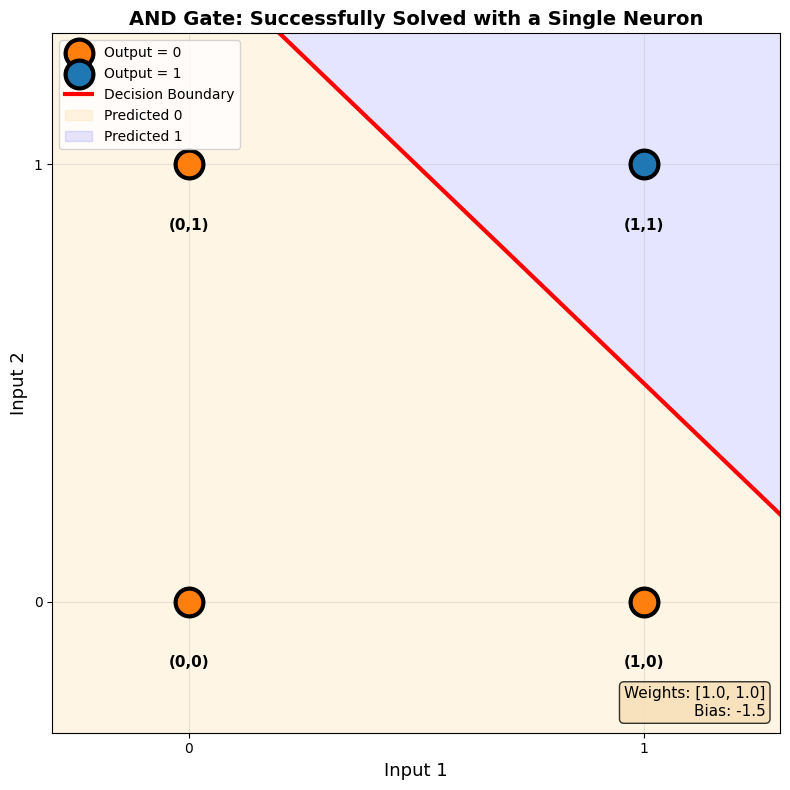


Notice how a single straight line perfectly separates the classes!
This is a linearly separable problem.


In [5]:
# Visualize the AND gate solution
def plot_gate_solution(X, y, perceptron, title, filename):
    """
    Plot the data points and decision boundary for a logic gate.
    """
    plt.figure(figsize=(8, 8))
    
    colors = ['#ff7f0e', '#1f77b4']
    labels_text = ['Output = 0', 'Output = 1']
    
    # Plot data points
    for i in range(2):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=colors[i], s=400, label=labels_text[i],
                   edgecolors='black', linewidth=3, zorder=3)
    
    # Add coordinate labels
    for idx, (x1, x2) in enumerate(X):
        plt.text(x1, x2-0.15, f"({x1},{x2})",
                ha='center', fontsize=11, fontweight='bold')
    
    # Plot decision boundary
    w = perceptron.weights.numpy()
    b = perceptron.bias.item()
    
    x1_range = np.array([-0.5, 1.5])
    
    # Decision boundary equation: w1*x1 + w2*x2 + b = 0
    # Solving for x2: x2 = -(w1*x1 + b) / w2
    if abs(w[1]) > 1e-6:
        x2_boundary = -(w[0] * x1_range + b) / w[1]
        plt.plot(x1_range, x2_boundary, 'r-', linewidth=3,
                label='Decision Boundary', zorder=2)
        
        # Shade the regions
        plt.fill_between(x1_range, -0.5, x2_boundary,
                        alpha=0.1, color='orange', label='Predicted 0')
        plt.fill_between(x1_range, x2_boundary, 1.5,
                        alpha=0.1, color='blue', label='Predicted 1')
    
    plt.xlabel('Input 1', fontsize=13)
    plt.ylabel('Input 2', fontsize=13)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlim(-0.3, 1.3)
    plt.ylim(-0.3, 1.3)
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.grid(True, alpha=0.3, zorder=1)
    plt.legend(loc='upper left', fontsize=10)
    
    # Add weight information
    info_text = f"Weights: [{w[0]:.1f}, {w[1]:.1f}]\nBias: {b:.1f}"
    plt.text(0.98, 0.02, info_text, transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

# Visualize AND gate solution
plot_gate_solution(X, y_and, and_perceptron,
                  'AND Gate: Successfully Solved with a Single Neuron',
                  'and_gate_solution.png')

print("\nNotice how a single straight line perfectly separates the classes!")
print("This is a linearly separable problem.")

## Step 5: Part B - Attempt the XOR gate

Now for the challenge: try to find weights that solve XOR. Spoiler: you won't succeed, but understanding why is crucial!

In [6]:
# Create tensors for XOR gate
X_xor_tensor = torch.FloatTensor(X)
y_xor_tensor = torch.FloatTensor(y_xor)

# TODO: Try to find weights that solve XOR (at least 3 different weight combinations)
# HINT: Don't try too hard to find the "right" answer - there isn't one! 
# **Strategic exploration**: Try to isolate each corner systematically:
#   > 1. First attempt: Can you separate (0,0) and (1,1) from (0,1) and (1,0)?
#   > 2. Second attempt: Can you separate (0,1) and (1,1) from the other two?
#   > 3. Third attempt: Try a diagonal line - can it work?
# The goal is to try several different lines and see that they all fail. 

xor_attempts = [
    {'weights': [1.0, 1.0], 'bias': -0.5, 'name': 'Attempt 1: Diagonal'},
    {'weights': [1.0, -1.0], 'bias': 0.0, 'name': 'Attempt 2: Opposite Diagonal'},
    {'weights': [0.0, 1.0], 'bias': -0.5, 'name': 'Attempt 3: Vertical'}
]  # Add your choices here with format {'weights': [], 'bias': , 'name': ''}

print("Attempting to solve XOR gate...\n")
best_accuracy = 0
best_config = None

for config in xor_attempts:
    xor_perceptron = Perceptron(input_size=2)
    xor_perceptron.set_weights(config['weights'], config['bias'])
    
    predictions, z_values = xor_perceptron.forward(X_xor_tensor)
    accuracy = xor_perceptron.accuracy(X_xor_tensor, y_xor_tensor)
    
    print(f"{config['name']}:")
    print(f"Weights: {config['weights']}, Bias: {config['bias']}")
    print(f"Accuracy: {accuracy:.1%}")
    print(f"Predictions: {predictions.numpy()} (Expected: {y_xor})")
    print()
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f"Best accuracy achieved: {best_accuracy:.1%}")
print(f"\nNOTICE: We can't get 100% accuracy!")
print(f"The best we can do is 50% (random guessing) or 75% (getting 3 out of 4 correct).")
print(f"This is because XOR is NOT linearly separable!")

Attempting to solve XOR gate...

Attempt 1: Diagonal:
Weights: [1.0, 1.0], Bias: -0.5
Accuracy: 75.0%
Predictions: [0. 1. 1. 1.] (Expected: [0 1 1 0])

Attempt 2: Opposite Diagonal:
Weights: [1.0, -1.0], Bias: 0.0
Accuracy: 75.0%
Predictions: [0. 0. 1. 0.] (Expected: [0 1 1 0])

Attempt 3: Vertical:
Weights: [0.0, 1.0], Bias: -0.5
Accuracy: 50.0%
Predictions: [0. 1. 0. 1.] (Expected: [0 1 1 0])

Best accuracy achieved: 75.0%

NOTICE: We can't get 100% accuracy!
The best we can do is 50% (random guessing) or 75% (getting 3 out of 4 correct).
This is because XOR is NOT linearly separable!


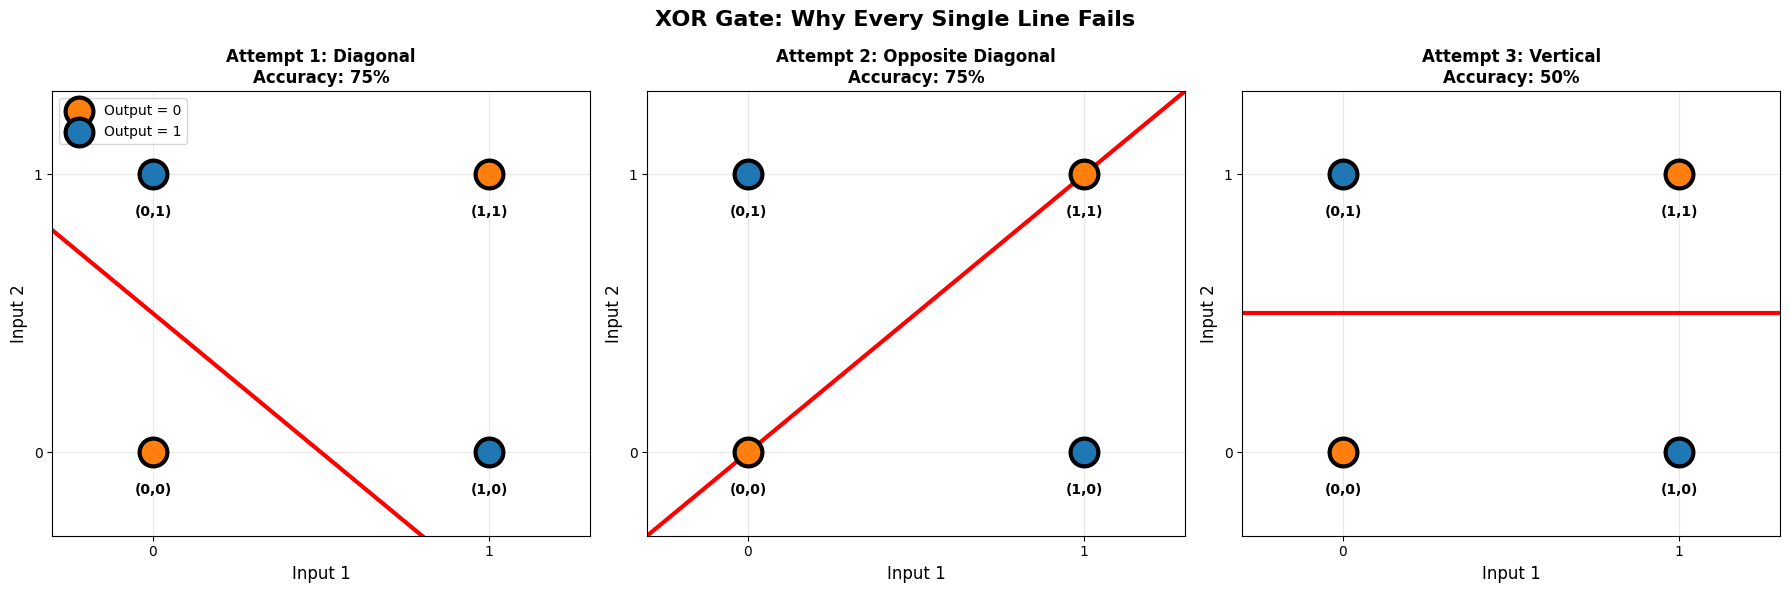


Key Insight: The XOR problem requires separating OPPOSITE CORNERS.
No single straight line can do this, we need a curved boundary!


In [7]:
# Visualize all XOR attempts to see why they all fail
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, config in enumerate(xor_attempts):
    ax = axes[idx]
    
    xor_perceptron = Perceptron(input_size=2)
    xor_perceptron.set_weights(config['weights'], config['bias'])
    
    colors = ['#ff7f0e', '#1f77b4']
    labels_text = ['Output = 0', 'Output = 1']
    
    # Plot data points
    for i in range(2):
        mask = y_xor == i
        ax.scatter(X[mask, 0], X[mask, 1],
                  c=colors[i], s=400, label=labels_text[i] if idx == 0 else '',
                  edgecolors='black', linewidth=3, zorder=3)
    
    # Add labels
    for i, (x1, x2) in enumerate(X):
        ax.text(x1, x2-0.15, f"({x1},{x2})",
               ha='center', fontsize=10, fontweight='bold')
    
    # Plot decision boundary
    w = np.array(config['weights'])
    b = config['bias']
    x1_range = np.array([-0.5, 1.5])
    
    if abs(w[1]) > 1e-6:
        x2_boundary = -(w[0] * x1_range + b) / w[1]
        ax.plot(x1_range, x2_boundary, 'r-', linewidth=3, zorder=2)
    else:
        if abs(w[0]) > 1e-6:
            x1_boundary = -b / w[0]
            ax.axvline(x=x1_boundary, color='r', linewidth=3, zorder=2)
    
    # Calculate accuracy
    accuracy = xor_perceptron.accuracy(X_xor_tensor, y_xor_tensor)
    
    ax.set_xlabel('Input 1', fontsize=12)
    ax.set_ylabel('Input 2', fontsize=12)
    ax.set_title(f"{config['name']}\nAccuracy: {accuracy:.0%}",
                fontsize=12, fontweight='bold')
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 1.3)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.grid(True, alpha=0.3, zorder=1)
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=10)

plt.suptitle('XOR Gate: Why Every Single Line Fails', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'xor_gate_attempts.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Insight: The XOR problem requires separating OPPOSITE CORNERS.")
print("No single straight line can do this, we need a curved boundary!")

> **The XOR problem and AI history**: In 1969, Marvin Minsky and Seymour Papert published "Perceptrons", mathematically proving that single-layer perceptrons cannot solve XOR. The breakthrough came decades later when researchers realized that **multiple layers** with **nonlinear decision rules** could solve XOR and much more complex problems. This is the foundation of modern deep learning.

## Step 6: Part C - Understanding why we need depth

Let's explore what happens when we use multiple neurons. Can two neurons working together solve XOR?

In [8]:
# Create two perceptrons that detect different patterns
# Neuron 1: Detects "at least one input is 1" (OR-like)
neuron1 = Perceptron(input_size=2)
neuron1.set_weights([1.0, 1.0], -0.5)

# Neuron 2: Detects "NOT both inputs are 1" (NAND-like)
neuron2 = Perceptron(input_size=2)
neuron2.set_weights([-1.0, -1.0], 1.5)

# Get outputs from both neurons
output1, z1 = neuron1.forward(X_xor_tensor)
output2, z2 = neuron2.forward(X_xor_tensor)

print("Two-Neuron Layer Outputs:")
print("\nInput  | Neuron 1 | Neuron 2 | Expected XOR")
print("-" * 50)
for i in range(len(X)):
    print(f"{X[i]} | {output1[i]:.0f}        | {output2[i]:.0f}        | {y_xor[i]:.0f}")

print("\nObservation:")
print("We now have TWO outputs per input, not one!")
print("Each neuron detects a different pattern:")
print("  • Neuron 1 outputs 1 when 'at least one input is 1' (OR-like)")
print("  • Neuron 2 outputs 1 when 'NOT both inputs are 1' (NAND-like)")
print("\nThe Question: How do we combine these two outputs into a single XOR decision?")

Two-Neuron Layer Outputs:

Input  | Neuron 1 | Neuron 2 | Expected XOR
--------------------------------------------------
[0 0] | 0        | 1        | 0
[0 1] | 1        | 1        | 1
[1 0] | 1        | 1        | 1
[1 1] | 1        | 0        | 0

Observation:
We now have TWO outputs per input, not one!
Each neuron detects a different pattern:
  • Neuron 1 outputs 1 when 'at least one input is 1' (OR-like)
  • Neuron 2 outputs 1 when 'NOT both inputs are 1' (NAND-like)

The Question: How do we combine these two outputs into a single XOR decision?


> **How to combine multiple neurons**: A single layer of neurons gives you multiple outputs in parallel, but you need **another layer** to combine them into a final decision. This is why neural networks have depth: each layer transforms the problem to make it easier for the next layer.

## Conclusion

Congratulations! You've completed a journey through the fundamentals and limitations of single-layer perceptrons. Here's what you've achieved:

- [x] **Implemented a perceptron from scratch** using PyTorch
- [x] **Solved the AND gate** by finding appropriate weights and bias
- [x] **Discovered XOR's impossibility** for single neurons (linearly inseparable)
- [x] **Understood why depth matters** by exploring multiple neurons

**Critical insights:**
- **Linear separability**: Single neurons can only draw straight lines
- **The XOR problem**: Some patterns require curved boundaries
- **The power of depth**: Multiple layers can combine simple boundaries into complex decision regions

Every neuron in every modern neural network—from image classifiers to language models—performs this same simple computation you just implemented. Understanding this building block is your key to understanding how deep learning works!

> **Next steps to explore**: Now that you understand why depth is necessary, you might want to learn about activation functions that enable non-linearity, and training algorithms that automatically learn optimal weights from data instead of manual trial-and-error.

---

## _(Optional) Bonus: Test on movie data_

Want to see this work on actual movies? The perceptron class you built works on 
ANY binary classification data—but you'll need different weights!

**Why?** The weights you found for AND gate (working on binary 0/1 inputs) won't 
transfer directly to normalized movie data (continuous 0-1 values). The geometry 
is different.

**Try this**:
```python
# Load movie data from demo (X_tensor, y_tensor)
movie_perceptron = Perceptron(input_size=2)

# Start with the demo's balanced weights that were tuned for movie data
movie_perceptron.set_weights([0.6, 0.8], -0.8)

predictions, z = movie_perceptron.forward(X_tensor)
accuracy = movie_perceptron.accuracy(X_tensor, y_tensor)
print(f"Movie classification accuracy: {accuracy:.1%}")

# Try experimenting with different weights!
```

**Key insight**: Your Perceptron CLASS is reusable (same code works on any data), but the WEIGHTS need to be tuned for each specific dataset. This is exactly why model training exists, to learn the weights for you!